In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys


notebook_dir = os.getcwd()  

emotions_dir   = os.path.abspath(os.path.join(notebook_dir, "..", "..", "emotions"))

context_dir = os.path.abspath(os.path.join(notebook_dir, "..", "..", "context"))

evaluation_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

sentiment_evaluation_dir = os.path.join(evaluation_dir, "sentiment")

for d in (emotions_dir, context_dir, evaluation_dir, sentiment_evaluation_dir):
    if d not in sys.path:
        sys.path.insert(0, d)

from song_evaluator import run_evaluation
from emotions import emotions_labels
from context import get_context_embedding
from utils import get_emotional_embedding, get_lyrics

In [3]:
RESULTS_STORAGE_PATH = "songs_results"
CSV_PROMPTS_PATH = "../sentiment/eval_prompts.csv"
IDX = {lbl: i for i, lbl in enumerate(emotions_labels)}

In [4]:
df = pd.read_csv(CSV_PROMPTS_PATH)

df["emotional_embeddings"] = df["text"].apply(get_emotional_embedding)
df["context_embeddings"] = df["text"].apply(get_context_embedding)
print(df.head())

                                                text       label  \
0  Watching my teammate stay late to coach the in...  admiration   
1  That clip of a golden retriever chasing bubble...   amusement   
2  The courier dumped my brand-new keyboard in a ...       anger   
3  The elevator keeps dinging on every floor even...   annoyance   
4  My colleague refactored the legacy code and no...    approval   

                                emotional_embeddings  \
0  [1.0743394, -6.483197, -6.709549, -5.0575614, ...   
1  [-4.153978, 1.2321672, -6.8980556, -5.5653696,...   
2  [-6.477596, -6.34222, -1.65582, -0.8595148, -4...   
3  [-5.5997, -6.7305875, -4.8331213, -1.1109929, ...   
4  [-3.7546933, -6.8430514, -7.565738, -5.4406056...   

                                  context_embeddings  
0  [0.00015752304, 0.015988145, -0.02959476, -0.0...  
1  [0.0032863289, 0.028587582, -0.014912383, 0.02...  
2  [0.012090489, 0.039330203, 0.021434383, 0.0222...  
3  [-0.0064753937, 0.03992142, -0.

## Search the best weights

In [ ]:
weights = [(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

for weight_emotion, weight_context in weights:
    print(f"Running evaluation with weights: emotion={weight_emotion}, context={weight_context}")
    # create a new df
    data = df.copy()
    data["lyrics_predictions"] = data.apply(
        lambda row: get_lyrics(
            row["emotional_embeddings"],
            row["context_embeddings"],
            weight_emotion=weight_emotion,
            weight_context=weight_context,
        ),
        axis=1,
    )
    data = data.drop(columns=["emotional_embeddings", "context_embeddings", "label"])

    evaluated_df = await run_evaluation(data)
    evaluated_df.to_csv(os.path.join(RESULTS_STORAGE_PATH, f"evaluated_lyrics_predictions_{weight_emotion}_{weight_context}.csv"), index=False)

Running evaluation with weights: emotion=0.1, context=0.9
Running evaluation with weights: emotion=0.2, context=0.8
Running evaluation with weights: emotion=0.3, context=0.7
Running evaluation with weights: emotion=0.4, context=0.6
Running evaluation with weights: emotion=0.5, context=0.5
Running evaluation with weights: emotion=0.6, context=0.4
Running evaluation with weights: emotion=0.7, context=0.3
Running evaluation with weights: emotion=0.8, context=0.2
Running evaluation with weights: emotion=0.9, context=0.1


In [6]:
def show_results(df):
    stats = df[[
        "emotional","contextual","coherence","overall"
    ]].describe().round(2)
    display(stats)


    plt.figure(figsize=(10, 4))

    # Histograma de puntajes globales
    plt.subplot(1, 2, 1)
    df["overall"].hist(bins=11)
    plt.title("Distribución de puntajes ‘overall’")
    plt.xlabel("Score (0-5)")
    plt.ylabel("Frecuencia")

    # Barra de promedios por criterio
    plt.subplot(1, 2, 2)
    (df[[
        "emotional", "contextual", "coherence", "overall"
    ]].mean()
    ).plot(kind="bar")
    plt.ylim(0, 5)
    plt.title("Promedio por criterio")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Score (0-5)")

    plt.tight_layout()
    plt.show()

    # # Top y bottom 5 songs recommendations
    # display(df.sort_values("overall", ascending=False)
    #         .head(5)[["text", "lyrics_predictions", "overall"]]
    #         .rename(columns={"overall": "score"}))

    # display(df.sort_values("overall", ascending=True)
    #         .head(5)[["text", "lyrics_predictions", "overall"]]
    #         .rename(columns={"overall": "score"}))

Filtered songs:  11
Not filtered songs:  97


,emotional,contextual,coherence,overall
count,97.00,97.00,97.00,97.00
mean,2.63,2.23,2.56,2.43
std,1.62,1.60,1.12,1.37
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.33
50%,3.00,2.00,2.00,3.00
75%,4.00,3.00,3.00,3.70
max,5.00,5.00,5.00,4.70


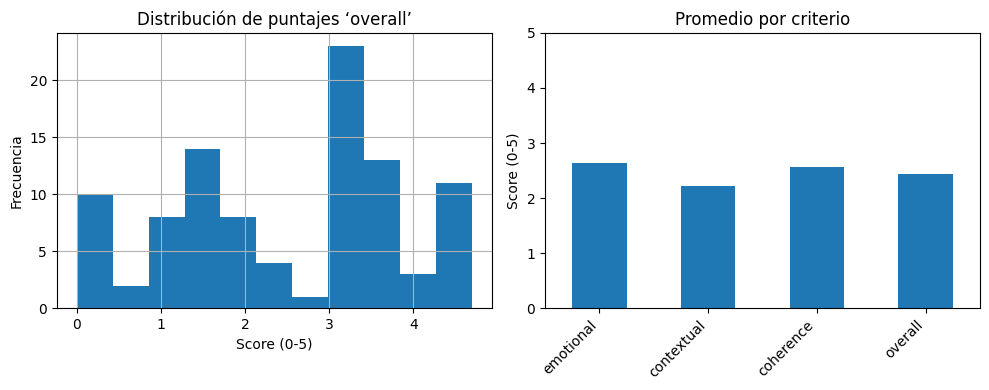

Filtered songs:  11
Not filtered songs:  97


,emotional,contextual,coherence,overall
count,97.00,97.00,97.00,97.00
mean,2.48,2.05,2.48,2.30
std,1.60,1.53,1.15,1.33
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.33
50%,3.00,2.00,2.00,2.30
75%,4.00,3.00,3.00,3.30
max,5.00,5.00,5.00,4.70


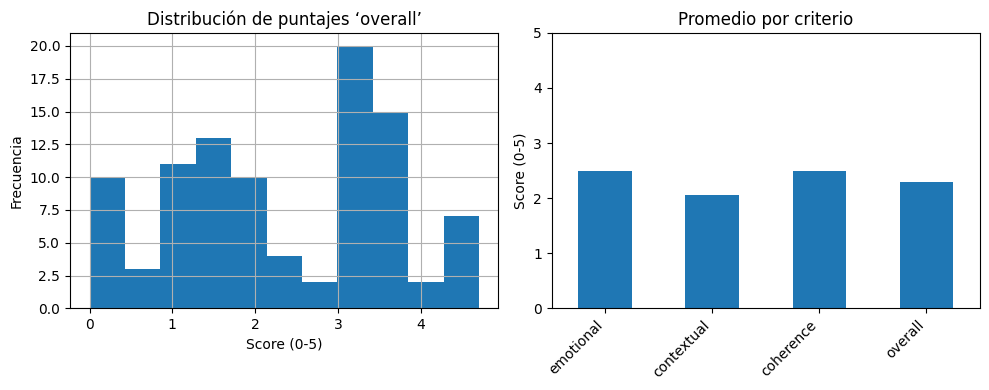

Filtered songs:  9
Not filtered songs:  99


,emotional,contextual,coherence,overall
count,99.00,99.00,99.00,99.00
mean,2.59,2.03,2.30,2.28
std,1.46,1.47,1.07,1.21
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.32
50%,3.00,2.00,2.00,2.30
75%,4.00,3.00,3.00,3.00
max,5.00,5.00,4.00,4.70


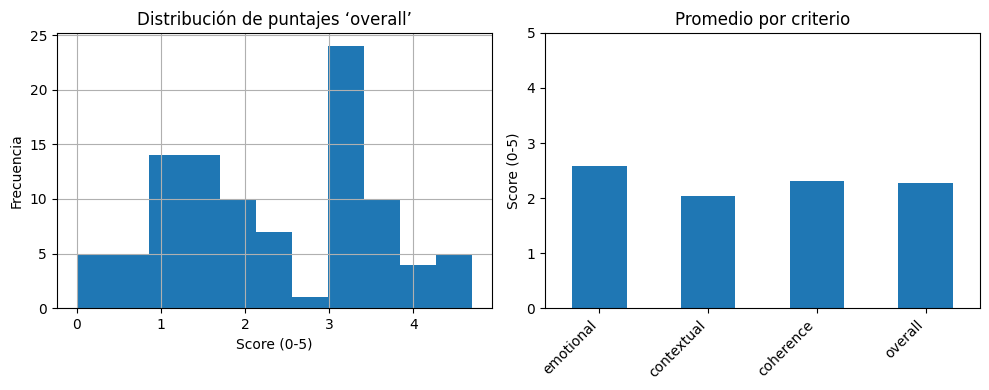

Filtered songs:  9
Not filtered songs:  99


,emotional,contextual,coherence,overall
count,99.00,99.00,99.00,99.00
mean,2.69,2.09,2.33,2.34
std,1.48,1.48,1.06,1.22
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.33
50%,3.00,2.00,2.00,2.30
75%,4.00,3.00,3.00,3.30
max,5.00,5.00,4.00,4.70


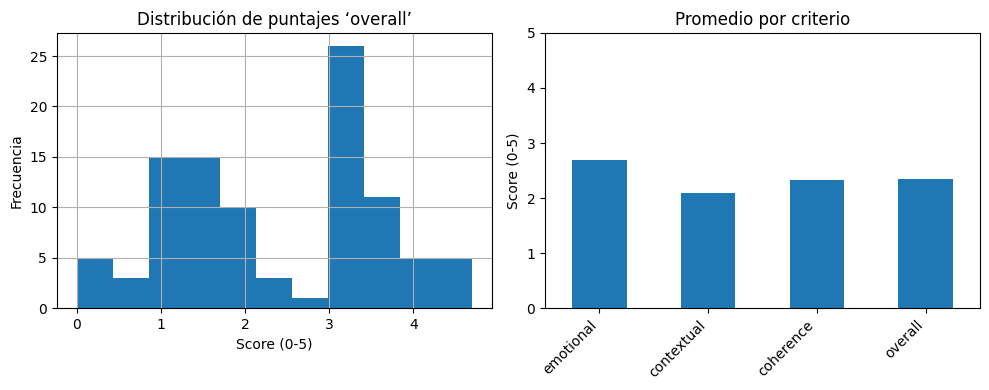

Filtered songs:  11
Not filtered songs:  97


,emotional,contextual,coherence,overall
count,97.00,97.00,97.00,97.00
mean,2.68,2.03,2.45,2.36
std,1.46,1.45,1.13,1.24
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.33
50%,3.00,2.00,2.00,2.33
75%,4.00,3.00,3.00,3.30
max,5.00,5.00,5.00,5.00


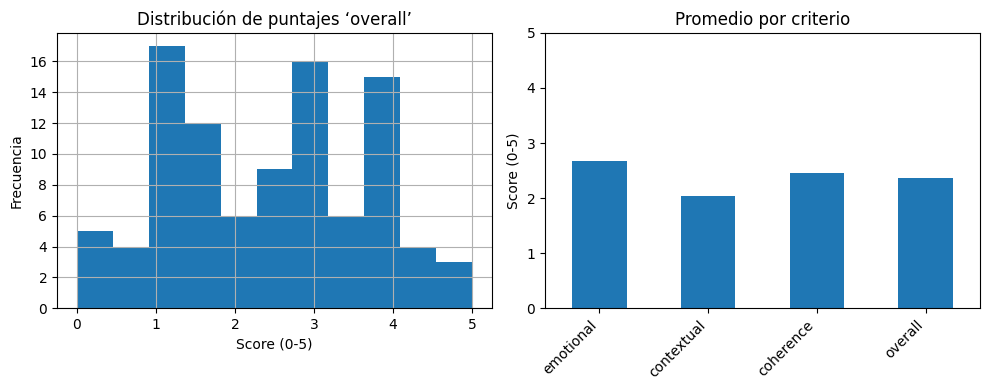

Filtered songs:  12
Not filtered songs:  96


,emotional,contextual,coherence,overall
count,96.00,96.00,96.00,96.00
mean,2.52,2.00,2.39,2.27
std,1.49,1.45,1.16,1.25
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.33
50%,2.00,2.00,2.00,2.00
75%,4.00,3.00,3.00,3.08
max,5.00,5.00,5.00,5.00


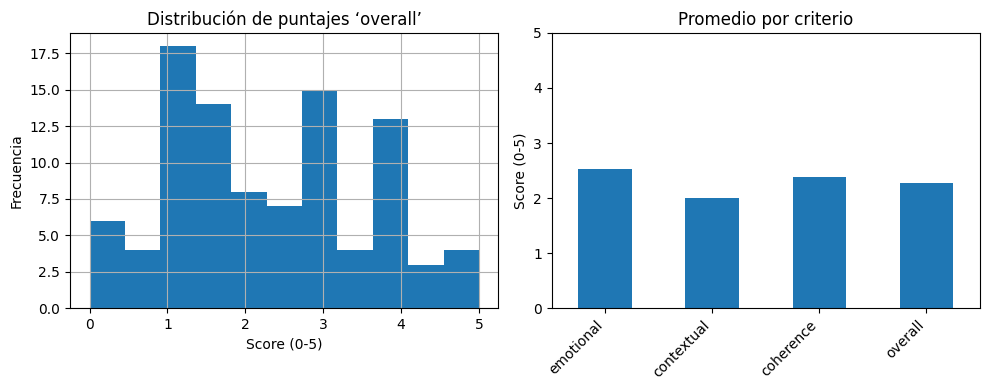

Filtered songs:  7
Not filtered songs:  101


,emotional,contextual,coherence,overall
count,101.00,101.00,101.00,101.00
mean,2.60,1.82,2.39,2.23
std,1.49,1.43,1.09,1.23
min,0.00,0.00,0.00,0.00
25%,1.00,1.00,2.00,1.00
50%,2.00,1.00,2.00,2.00
75%,4.00,3.00,3.00,3.00
max,5.00,5.00,4.00,4.70


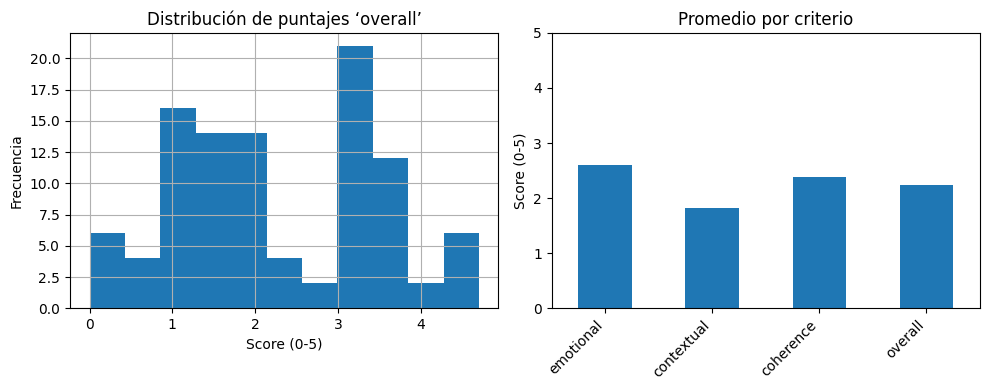

Filtered songs:  9
Not filtered songs:  99


,emotional,contextual,coherence,overall
count,99.00,99.00,99.00,99.00
mean,2.68,1.95,2.58,2.37
std,1.46,1.36,1.02,1.18
min,0.00,0.00,1.00,0.00
25%,1.00,1.00,2.00,1.33
50%,3.00,2.00,2.00,2.30
75%,4.00,3.00,3.00,3.30
max,5.00,5.00,5.00,4.70


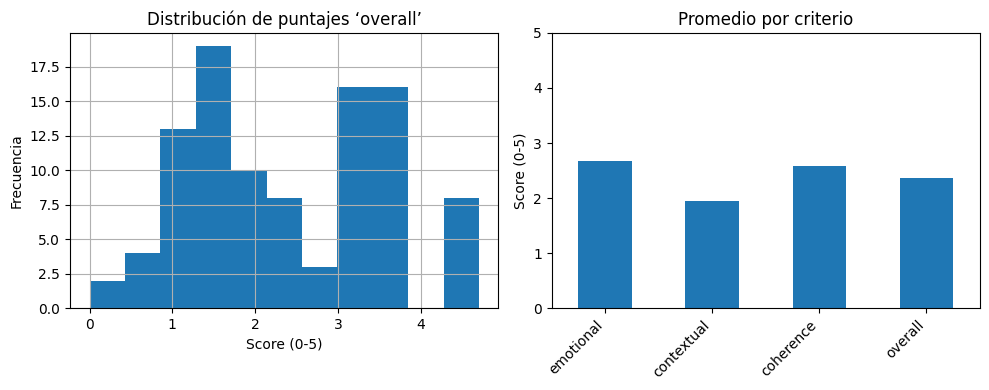

Filtered songs:  11
Not filtered songs:  97


,emotional,contextual,coherence,overall
count,97.00,97.00,97.00,97.00
mean,2.84,2.06,2.48,2.44
std,1.43,1.34,1.00,1.13
min,0.00,0.00,1.00,0.00
25%,1.00,1.00,2.00,1.33
50%,3.00,2.00,2.00,2.70
75%,4.00,3.00,3.00,3.30
max,5.00,5.00,4.00,4.70


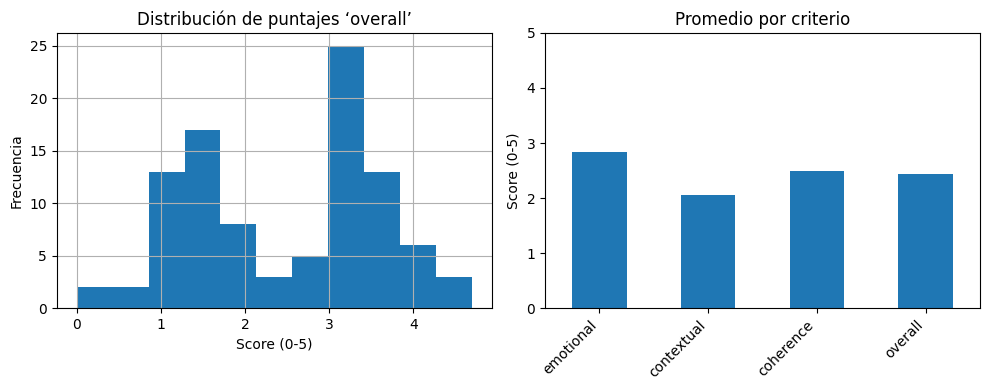

In [7]:
best_results = {"overall": {"score":0, "weights": (0, 0)}, "emotional": {"score":0, "weights": (0, 0)},
                "contextual": {"score":0, "weights": (0, 0)}, "coherence": {"score":0, "weights": (0, 0)}}
for i, (weight_emotion, weight_context) in enumerate(weights):
    evaluated_df = pd.read_csv(os.path.join(RESULTS_STORAGE_PATH, f"evaluated_lyrics_predictions_{weight_emotion}_{weight_context}.csv"))
    df_filtered = evaluated_df[evaluated_df["rationale"].str.contains("The song was filtered out by the content filter")]
    df_not_filtered = evaluated_df[~evaluated_df["rationale"].str.contains("The song was filtered out by the content filter")]

    print("Filtered songs: ", len(df_filtered))
    print("Not filtered songs: ", len(df_not_filtered))
    show_results(df_not_filtered)
    for col in ["overall", "emotional", "contextual", "coherence"]:
        score = df_not_filtered[col].mean()
        if score > best_results[col]["score"]:
            best_results[col]["score"] = score
            best_results[col]["weights"] = (weight_emotion, weight_context)
    

In [8]:
print("Best results:")
for col, result in best_results.items():
    print(f"{col}: {result['score']} with weights {result['weights']}")

Best results:
overall: 2.43979381443299 with weights (0.9, 0.1)
emotional: 2.8350515463917527 with weights (0.9, 0.1)
contextual: 2.2268041237113403 with weights (0.1, 0.9)
coherence: 2.5757575757575757 with weights (0.8, 0.2)
